# Kenn Experiments - Plots and Statistics
Run this notebook only after all the tests have been run. 

In [1]:
from model import *
from pre_elab import *
from evaluation_functions import *
import settings as s
import pickle

# Inductive Learning 

## 3 KENN layers, e2e

In [2]:
with open('results/e2e/results_inductive_500','rb') as input:
    history_inductive = pickle.load(input)

In [3]:
# plot_losses(history_100runs_inductive_3l)

In [4]:
# plot_accuracies(history_20runs_inductive_3l)

== 10% ==
Mean Test Accuracy:	NN = 0.543966; KENN = 0.591556
Test Accuracy std:	NN = 0.060093; KENN = 0.055222
			Deltas Mean = 0.047591
			Deltas Std = 0.080025
			right tailed p-value: 3.085098236254701e-36

== 25% ==
Mean Test Accuracy:	NN = 0.629543; KENN = 0.670805
Test Accuracy std:	NN = 0.019920; KENN = 0.015488
			Deltas Mean = 0.041262
			Deltas Std = 0.022021
			right tailed p-value: 1.7971168339729523e-186

== 50% ==
Mean Test Accuracy:	NN = 0.679635; KENN = 0.714310
Test Accuracy std:	NN = 0.019224; KENN = 0.013485
			Deltas Mean = 0.034675
			Deltas Std = 0.022007
			right tailed p-value: 2.912802326776726e-162

== 75% ==
Mean Test Accuracy:	NN = 0.733157; KENN = 0.753947
Test Accuracy std:	NN = 0.024646; KENN = 0.017082
			Deltas Mean = 0.020790
			Deltas Std = 0.026766
			right tailed p-value: 6.033574389708137e-49

== 90% ==
Mean Test Accuracy:	NN = 0.758828; KENN = 0.768489
Test Accuracy std:	NN = 0.027678; KENN = 0.024150
			Deltas Mean = 0.009662
			Deltas Std = 0.02

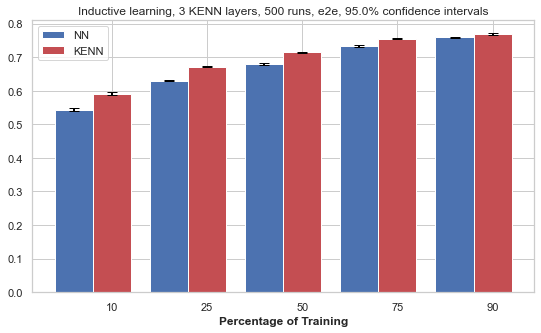

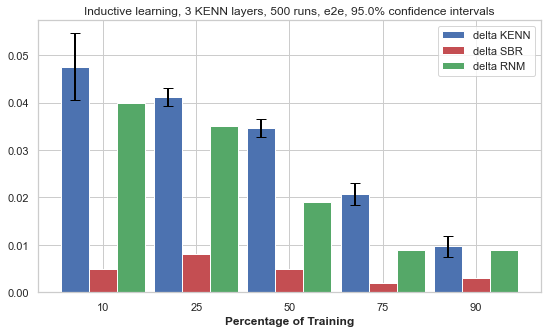

In [5]:
conf= 0.95

print_and_plot_results(
    history_inductive, 
    plot_title="Inductive learning, 3 KENN layers, 500 runs, e2e, {}% confidence intervals".format(conf*100),
    other_deltas='i',
    confidence_level=conf)

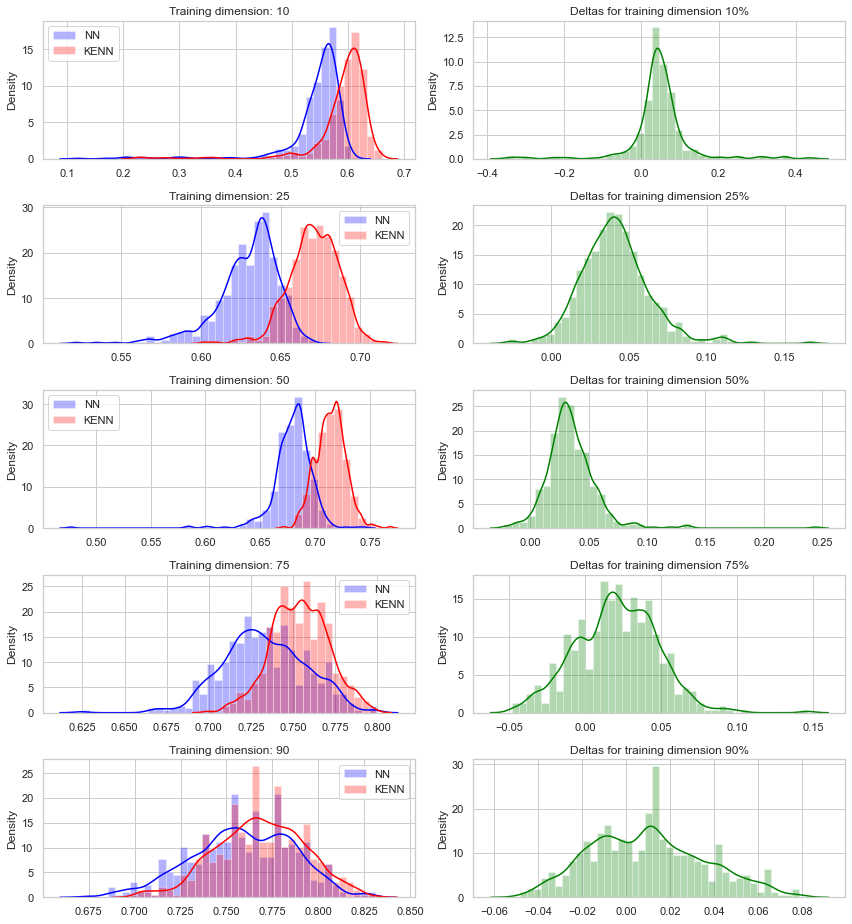

In [6]:
plot_histograms(history_inductive, 'history_inductive', bw=0.6, bins=40)

## 3 KENN layers, greedy

In [7]:
with open('results/greedy/results_inductive_500_g','rb') as input:
    history_inductive_g = pickle.load(input)

In [8]:
# plot_losses(history_20runs_inductive_3l_g)

In [9]:
# plot_accuracies(history_20runs_inductive_3l_g)

== 10% ==
Mean Test Accuracy:	NN = 0.545359; KENN = 0.558965
Test Accuracy std:	NN = 0.051283; KENN = 0.054538
			Deltas Mean = 0.013606
			Deltas Std = 0.007516
			right tailed p-value: 2.645902905083646e-05

== 25% ==
Mean Test Accuracy:	NN = 0.628940; KENN = 0.638025
Test Accuracy std:	NN = 0.024270; KENN = 0.025543
			Deltas Mean = 0.009085
			Deltas Std = 0.004751
			right tailed p-value: 5.613393374721372e-09

== 50% ==
Mean Test Accuracy:	NN = 0.679847; KENN = 0.684948
Test Accuracy std:	NN = 0.018918; KENN = 0.019332
			Deltas Mean = 0.005101
			Deltas Std = 0.003290
			right tailed p-value: 1.3738324364711793e-05

== 75% ==
Mean Test Accuracy:	NN = 0.732396; KENN = 0.734604
Test Accuracy std:	NN = 0.027116; KENN = 0.026934
			Deltas Mean = 0.002208
			Deltas Std = 0.002498
			right tailed p-value: 0.09861499947745597

== 90% ==
Mean Test Accuracy:	NN = 0.760254; KENN = 0.761009
Test Accuracy std:	NN = 0.029604; KENN = 0.029438
			Deltas Mean = 0.000755
			Deltas Std = 0.002186

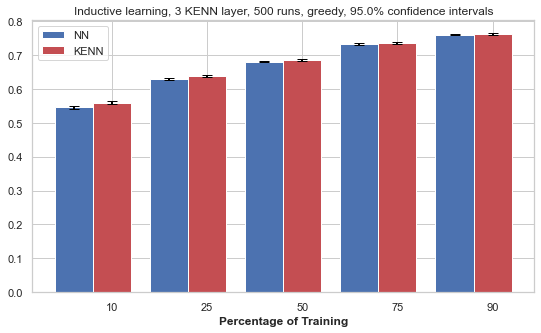

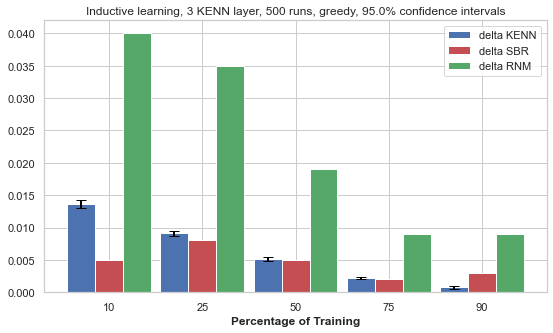

In [29]:
conf= 0.95

print_and_plot_results(
    history_inductive_g, 
    plot_title="Inductive learning, 3 KENN layer, 500 runs, greedy, {}% confidence intervals".format(conf*100),
    other_deltas='i',
    confidence_level=conf)

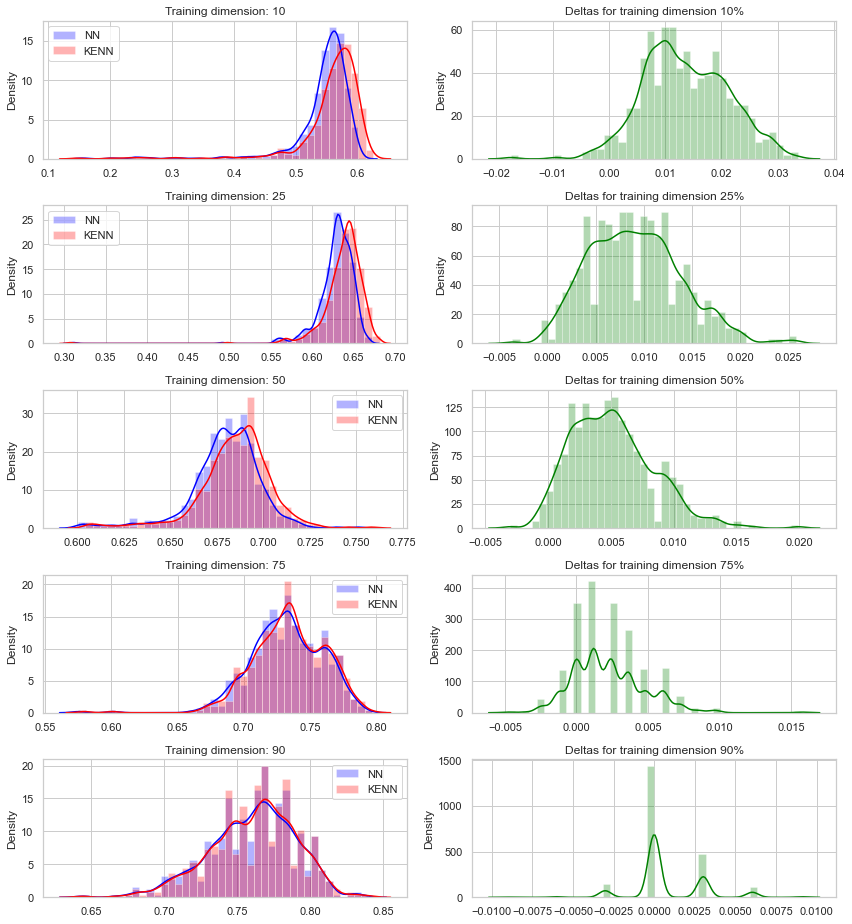

In [11]:
plot_histograms(history_inductive_g, 'history_inductive_g', bw=0.6, bins=40)

# Transductive Learning

## 3 KENN layers, e2e

In [14]:
with open('results/e2e/results_transductive_500','rb') as input:
    history_transductive = pickle.load(input)

In [14]:
# plot_losses(history_20runs_transductive_3l)

In [15]:
# plot_accuracies(history_20runs_transductive_3l)

== 10% ==
Mean Test Accuracy:	NN = 0.543971; KENN = 0.651944
Test Accuracy std:	NN = 0.060092; KENN = 0.015203
			Deltas Mean = 0.107972
			Deltas Std = 0.059021
			right tailed p-value: 1.4493095868889297e-202

== 25% ==
Mean Test Accuracy:	NN = 0.629535; KENN = 0.702190
Test Accuracy std:	NN = 0.019921; KENN = 0.012466
			Deltas Mean = 0.072655
			Deltas Std = 0.022009
			right tailed p-value: 0.0

== 50% ==
Mean Test Accuracy:	NN = 0.679662; KENN = 0.744209
Test Accuracy std:	NN = 0.019238; KENN = 0.013879
			Deltas Mean = 0.064547
			Deltas Std = 0.022497
			right tailed p-value: 0.0

== 75% ==
Mean Test Accuracy:	NN = 0.733157; KENN = 0.788355
Test Accuracy std:	NN = 0.024646; KENN = 0.017632
			Deltas Mean = 0.055198
			Deltas Std = 0.026672
			right tailed p-value: 1.8765471052169025e-214

== 90% ==
Mean Test Accuracy:	NN = 0.758828; KENN = 0.808103
Test Accuracy std:	NN = 0.027678; KENN = 0.022381
			Deltas Mean = 0.049275
			Deltas Std = 0.026307
			right tailed p-value: 4.175

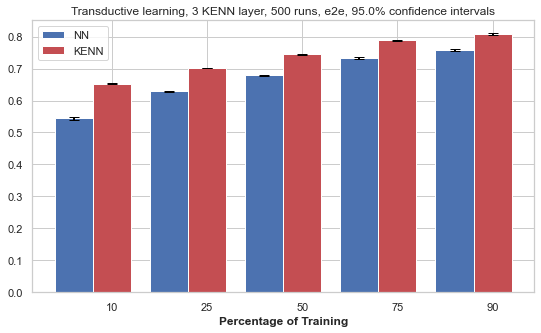

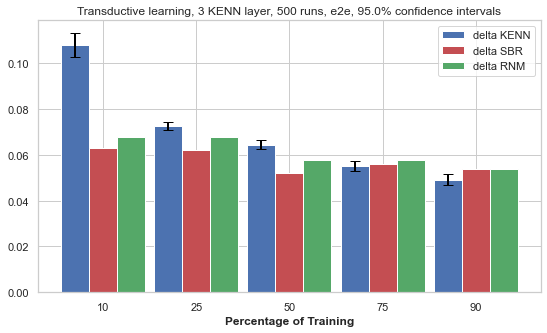

In [28]:
conf= 0.95

print_and_plot_results(
    history_transductive, 
    plot_title="Transductive learning, 3 KENN layer, 500 runs, e2e, {}% confidence intervals".format(conf*100),
    other_deltas='t',
    confidence_level=conf)

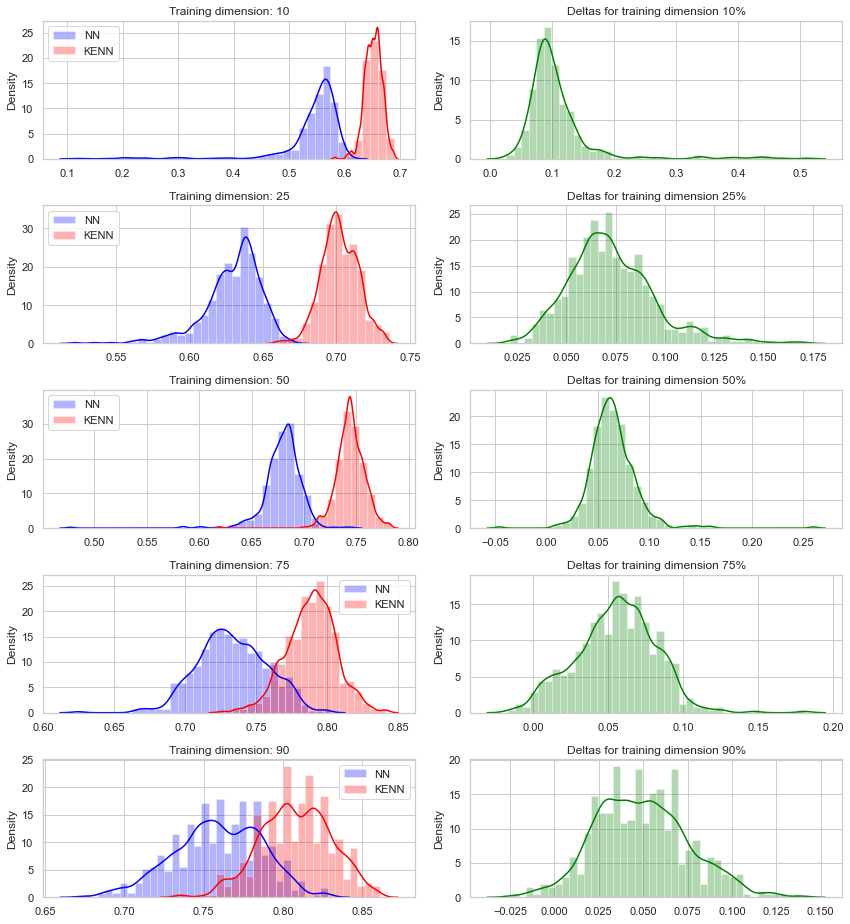

In [16]:
plot_histograms(history_transductive, 'history_transductive', bw=0.6, bins=40)

## 3 KENN layers, greedy

In [22]:
with open('results/greedy/results_transductive_500_g','rb') as input:
    history_transductive_g = pickle.load(input)

In [23]:
# plot_losses(history_20runs_transductive_3l_g)

In [24]:
# plot_accuracies(history_20runs_transductive_3l_g)

== 10% ==
Mean Test Accuracy:	NN = 0.545370; KENN = 0.561053
Test Accuracy std:	NN = 0.051286; KENN = 0.053680
			Deltas Mean = 0.015683
			Deltas Std = 0.007908
			right tailed p-value: 1.356009967135052e-06

== 25% ==
Mean Test Accuracy:	NN = 0.628931; KENN = 0.641120
Test Accuracy std:	NN = 0.024275; KENN = 0.025718
			Deltas Mean = 0.012189
			Deltas Std = 0.006016
			right tailed p-value: 1.6416012298426105e-14

== 50% ==
Mean Test Accuracy:	NN = 0.679833; KENN = 0.689638
Test Accuracy std:	NN = 0.018921; KENN = 0.019529
			Deltas Mean = 0.009804
			Deltas Std = 0.005443
			right tailed p-value: 1.1324020246991425e-15

== 75% ==
Mean Test Accuracy:	NN = 0.732396; KENN = 0.740599
Test Accuracy std:	NN = 0.027116; KENN = 0.026561
			Deltas Mean = 0.008203
			Deltas Std = 0.005652
			right tailed p-value: 7.995426852976397e-07

== 90% ==
Mean Test Accuracy:	NN = 0.760254; KENN = 0.766260
Test Accuracy std:	NN = 0.029604; KENN = 0.029518
			Deltas Mean = 0.006006
			Deltas Std = 0.006

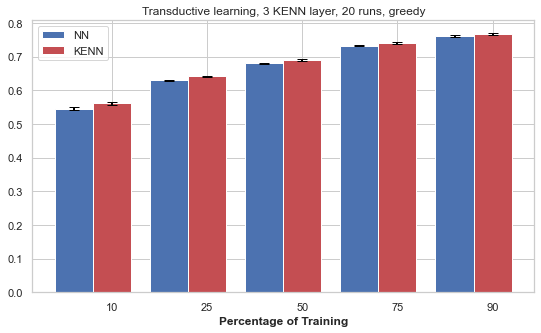

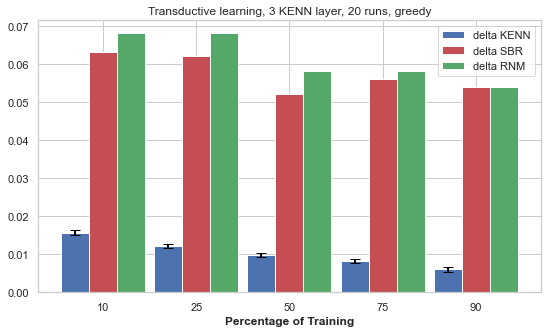

In [25]:
print_and_plot_results(
    history_transductive_g, 
    plot_title="Transductive learning, 3 KENN layer, 20 runs, greedy",
    other_deltas='t')

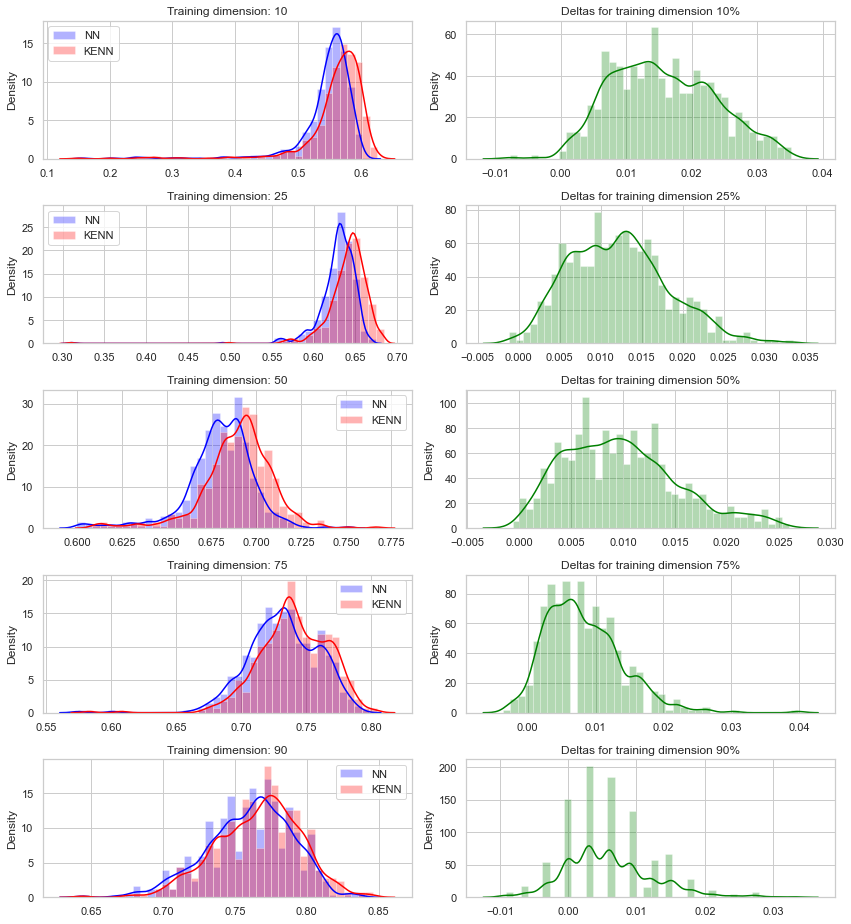

In [26]:
plot_histograms(history_transductive_g, 'history_transductive', bw=0.6, bins=40)

## Clause Weights Inspection
- Vedere se il valore dei pesi rispecchia il soddisfacimento dei vincoli nel training set
- Vedere come variano i clause weights al variare della training dimension

In [10]:
from training_inductive import train_and_evaluate_kenn_inductive
from training_transductive import train_and_evaluate_kenn_transductive
from pre_elab import generate_dataset, get_train_and_valid_lengths
from evaluation_functions import *
import matplotlib.pyplot as plt
import numpy as np
import settings as s
import tensorflow as tf

In [2]:
generate_dataset(0.9, verbose=False)

C:\Users\ricca\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3347: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
history_ind = train_and_evaluate_kenn_inductive(0.9, verbose=False)

*CB_ES* Validation Accuracy didn't increase in the last 10 epochs
*CB_ES* delta: 0.00067460537
callback_early_stopping signal received at epoch= 33/300
Terminating training 
Test Accuracy: 0.7885196208953857


In [4]:
history_tra = train_and_evaluate_kenn_transductive(0.9, verbose=False)

*CB_ES* Validation Accuracy didn't increase in the last 10 epochs
*CB_ES* delta: -0.0050590634
callback_early_stopping signal received at epoch= 43/300
Terminating training 
Test Accuracy: 0.8006042242050171


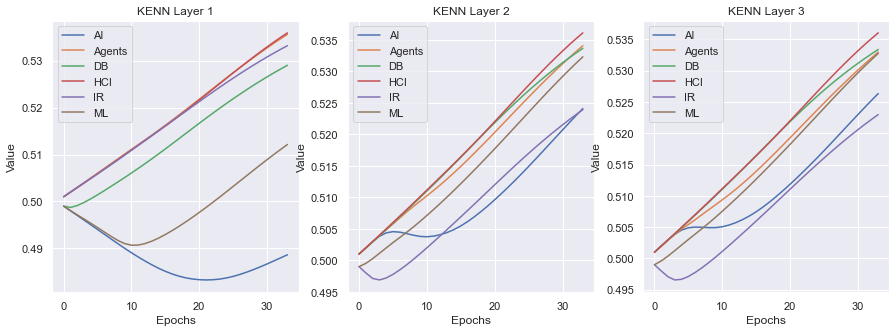

In [11]:
plot_clause_weights(history_ind)

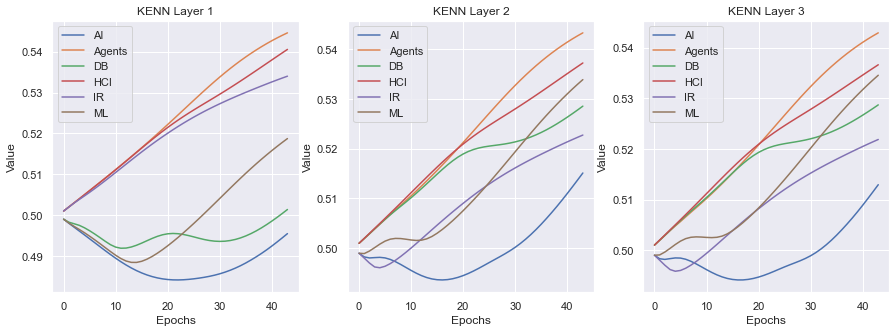

In [12]:
plot_clause_weights(history_tra)

## How much does the training set comply with out Base Knowledge?

Here we try to inspect how much our training data comply with the base knowledge (i.e. what is the proportion of samples that respect the logical rules we gave as input, for each clause?)

In [18]:
id_x_train = np.load('dataset/CiteSeer/index_x_inductive_training.npy')
id_y_train = np.load('dataset/CiteSeer/index_y_inductive_training.npy')
labels = np.load('dataset/CiteSeer/labels.npy')
features = np.load('dataset/CiteSeer/features.npy')

topics = ["AI","Agents","DB","HCI","IR","ML"]

generate_dataset(0.9, verbose=False)
train_len, valid_len = get_train_and_valid_lengths(features, 0.9)
train_labels = labels[:train_len]

In [53]:
total_cited_nodes = {
    "AI":0,
    "Agents":0,
    "DB":0,
    "HCI":0,
    "IR":0,
    "ML":0
}

same_topic_cited_nodes = {
    "AI":0,
    "Agents":0,
    "DB":0,
    "HCI":0,
    "IR":0,
    "ML":0
}

verbose = False
for i in range(train_len):
    # indexes of nodes pointed by edges coming from i
    is_topic = topics[np.where(train_labels[i].squeeze()==1)[0][0]]
    pointed_by_i_indexes = np.where(id_x_train.squeeze()==i)[0].tolist()
    pointed_by_i = id_y_train.squeeze()[pointed_by_i_indexes].tolist()
    if pointed_by_i != []:
        total_cited_nodes[is_topic] +=len(pointed_by_i)
        topics_of_pointed_by_i = []
        for j in pointed_by_i:
            js_topic = topics[np.where(train_labels[j].squeeze()==1)[0][0]]
            topics_of_pointed_by_i.append(js_topic)
            if js_topic == is_topic:
                same_topic_cited_nodes[is_topic] += 1
        
        if verbose:
            print("-- Looking at index {} --".format(i))
            print("Doc. {}'s topic: {}".format(
                i,
                is_topic))

            print("Topics of documents pointed by doc. {}: {}".format(
                i,
                topics_of_pointed_by_i))

In [54]:
print(total_cited_nodes)
print(same_topic_cited_nodes)

{'AI': 255, 'Agents': 415, 'DB': 402, 'HCI': 353, 'IR': 535, 'ML': 410}
{'AI': 113, 'Agents': 315, 'DB': 287, 'HCI': 307, 'IR': 437, 'ML': 255}


In [55]:
clause_compliance = {
    'AI' : same_topic_cited_nodes['AI']/total_cited_nodes['AI'],
    'Agents' : same_topic_cited_nodes['Agents']/total_cited_nodes['Agents'],
    'DB' : same_topic_cited_nodes['DB']/total_cited_nodes['DB'],
    'HCI' : same_topic_cited_nodes['HCI']/total_cited_nodes['HCI'],
    'IR' : same_topic_cited_nodes['IR']/total_cited_nodes['IR'],
    'ML' : same_topic_cited_nodes['ML']/total_cited_nodes['ML']
}
clause_compliance

{'AI': 0.44313725490196076,
 'Agents': 0.7590361445783133,
 'DB': 0.7139303482587065,
 'HCI': 0.8696883852691218,
 'IR': 0.8168224299065421,
 'ML': 0.6219512195121951}

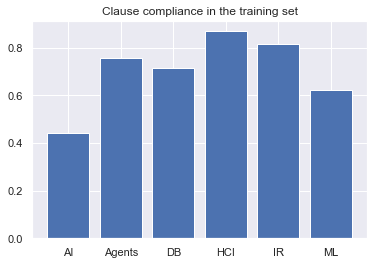

In [56]:
plt.bar(topics, list(clause_compliance.values()))
plt.title("Clause compliance in the training set")
plt.show()